<a href="https://colab.research.google.com/github/pr-shukla/MS-Thesis/blob/main/dqn_pur_evad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:

#Time Difference Between 2 Steps
dt = 0.4


#Minimum turing radius of Pursuer
rho = 0.3

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4



In [ ]:
EPISODES = 1000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='selu'))
        model.add(Dense(24, activation='selu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, rew, next_state):
        self.memory.append((state, action, rew, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        acti = np.argmax(act_values[0])
        #print(float(acti))
        return np.argmax(act_values[0]) # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, rew, next_state in minibatch:
            target = rew
            target = (rew + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
  #rewards = []
  
  r1 = 10*np.exp(-3*state[0])
  r2 = 10*np.exp(-1*state[1])
  r3 = 5*np.arctan(1*state[2])
  #r4 = 5*np.exp(-3*state[2])
  #r5 = 10*np.exp(-1*state[0+i*3]*state[2+i*3])
  r =  r1 #+ r2  #+ r3 

  #print(state)

  return r

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/d, 4))
    return angle

In [ ]:
import random
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = 5.0
    self.e_ry = 5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    return state_p1_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    
    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs

In [ ]:
state_size = 3
action_size = 3
agent = DQNAgent(state_size, action_size)

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Episode * 1 * Avg Reward is ==> 270.8410558926714


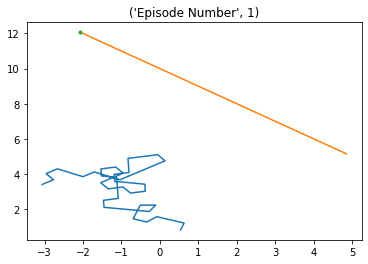

Current Episode: 2 Current Time Step: 0
Current Episode: 2 Current Time Step: 25
Episode * 2 * Avg Reward is ==> 217.6352294780627


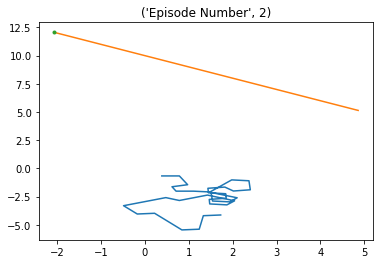

Current Episode: 3 Current Time Step: 0
Current Episode: 3 Current Time Step: 25
Episode * 3 * Avg Reward is ==> 205.50336313843357


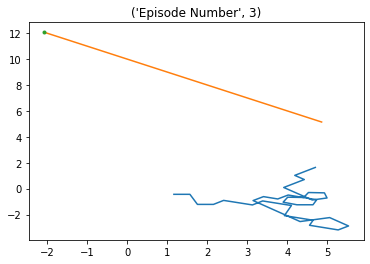

Current Episode: 4 Current Time Step: 0
Current Episode: 4 Current Time Step: 25
Episode * 4 * Avg Reward is ==> 196.7321258558904


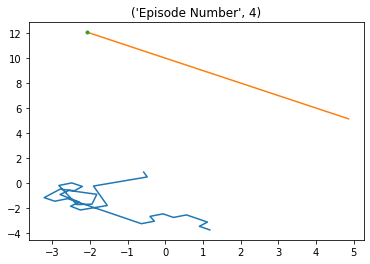

Current Episode: 5 Current Time Step: 0
Current Episode: 5 Current Time Step: 25
Episode * 5 * Avg Reward is ==> 193.26355216564843


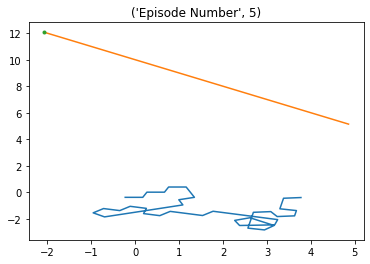

Current Episode: 6 Current Time Step: 0
Current Episode: 6 Current Time Step: 25
Episode * 6 * Avg Reward is ==> 186.23923761496746


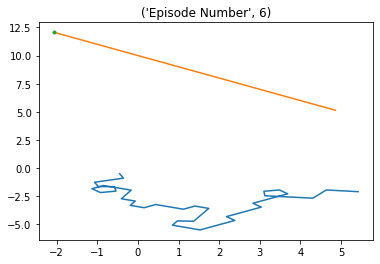

Current Episode: 7 Current Time Step: 0
Current Episode: 7 Current Time Step: 25
Episode * 7 * Avg Reward is ==> 192.0441667477315


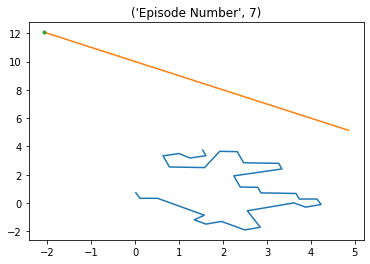

Current Episode: 8 Current Time Step: 0
Current Episode: 8 Current Time Step: 25
Episode * 8 * Avg Reward is ==> 186.8230766182699


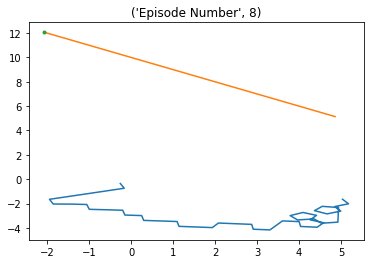

Current Episode: 9 Current Time Step: 0
Current Episode: 9 Current Time Step: 25
Episode * 9 * Avg Reward is ==> 190.00760534256128


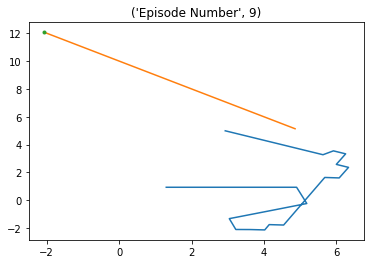

Current Episode: 10 Current Time Step: 0
Current Episode: 10 Current Time Step: 25
Episode * 10 * Avg Reward is ==> 206.03325779681532


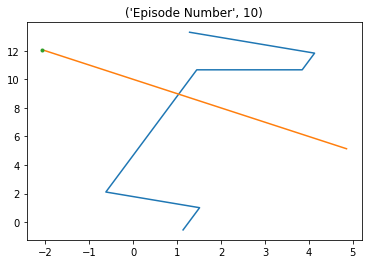

Current Episode: 11 Current Time Step: 0
Current Episode: 11 Current Time Step: 25
Episode * 11 * Avg Reward is ==> 212.611057222644


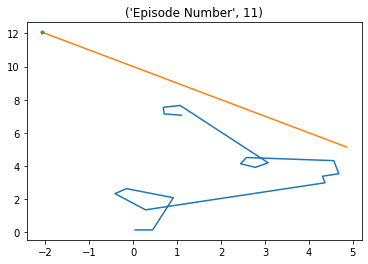

Current Episode: 12 Current Time Step: 0
Current Episode: 12 Current Time Step: 25
Episode * 12 * Avg Reward is ==> 222.64827767652358


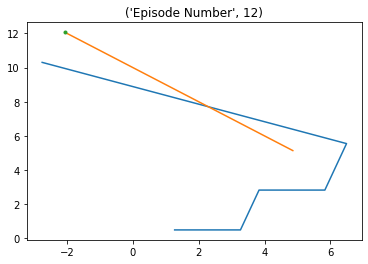

Current Episode: 13 Current Time Step: 0
Current Episode: 13 Current Time Step: 25
Episode * 13 * Avg Reward is ==> 230.0042635733736


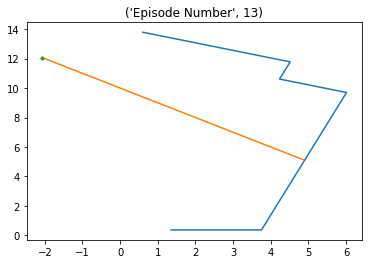

Current Episode: 14 Current Time Step: 0
Current Episode: 14 Current Time Step: 25
Episode * 14 * Avg Reward is ==> 236.352442547508


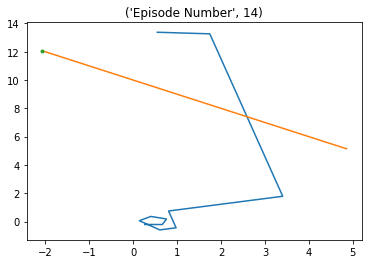

Current Episode: 15 Current Time Step: 0
Current Episode: 15 Current Time Step: 25
Episode * 15 * Avg Reward is ==> 244.3448782246674


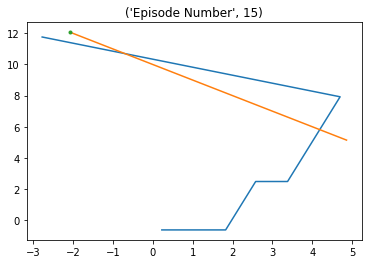

Current Episode: 16 Current Time Step: 0
Current Episode: 16 Current Time Step: 25
Episode * 16 * Avg Reward is ==> 249.95829823975458


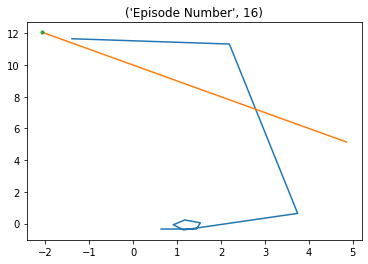

Current Episode: 17 Current Time Step: 0
Current Episode: 17 Current Time Step: 25
Episode * 17 * Avg Reward is ==> 258.5530526039892


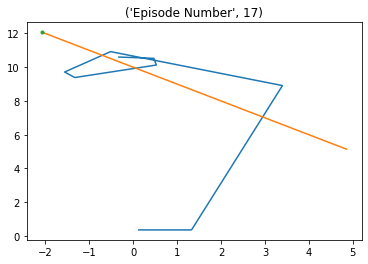

Current Episode: 18 Current Time Step: 0
Current Episode: 18 Current Time Step: 25
Episode * 18 * Avg Reward is ==> 263.9282384267905


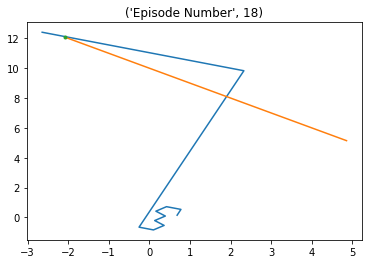

Current Episode: 19 Current Time Step: 0
Current Episode: 19 Current Time Step: 25
Episode * 19 * Avg Reward is ==> 269.80097146436293


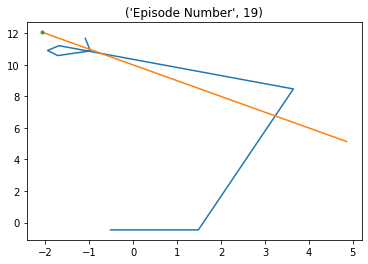

Current Episode: 20 Current Time Step: 0
Current Episode: 20 Current Time Step: 25
Episode * 20 * Avg Reward is ==> 275.1245793460677


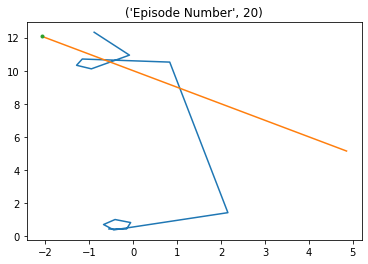

Current Episode: 21 Current Time Step: 0
Current Episode: 21 Current Time Step: 25
Episode * 21 * Avg Reward is ==> 275.2632586020885


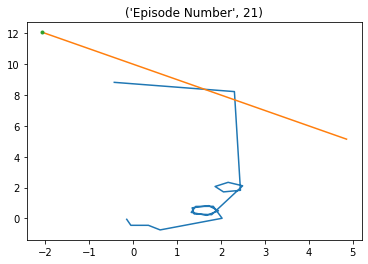

Current Episode: 22 Current Time Step: 0
Current Episode: 22 Current Time Step: 25
Episode * 22 * Avg Reward is ==> 280.3763482992113


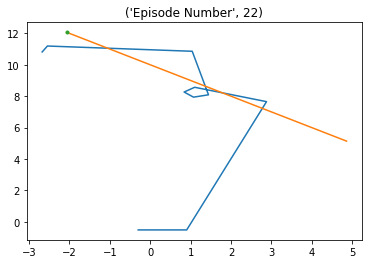

Current Episode: 23 Current Time Step: 0
Current Episode: 23 Current Time Step: 25
Episode * 23 * Avg Reward is ==> 286.1137219041998


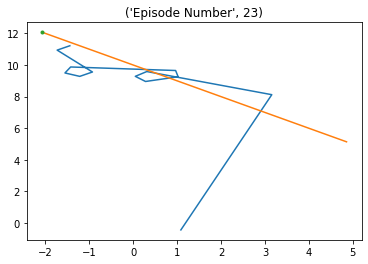

Current Episode: 24 Current Time Step: 0
Current Episode: 24 Current Time Step: 25
Episode * 24 * Avg Reward is ==> 292.1808602645477


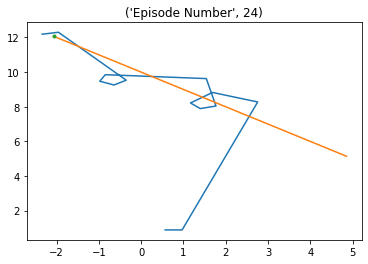

Current Episode: 25 Current Time Step: 0
Current Episode: 25 Current Time Step: 25
Episode * 25 * Avg Reward is ==> 296.4816837455499


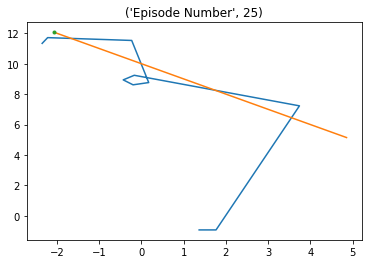

Current Episode: 26 Current Time Step: 0
Current Episode: 26 Current Time Step: 25
Episode * 26 * Avg Reward is ==> 300.59938414610696


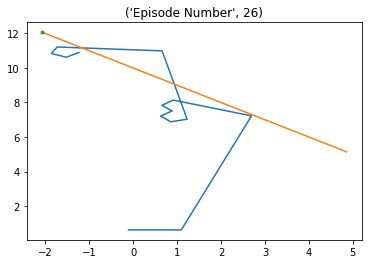

Current Episode: 27 Current Time Step: 0
Current Episode: 27 Current Time Step: 25
Episode * 27 * Avg Reward is ==> 304.4817221783366


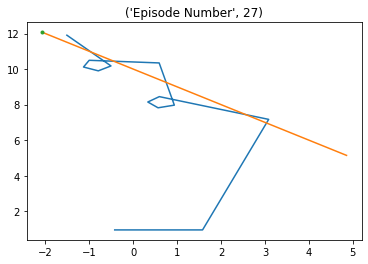

Current Episode: 28 Current Time Step: 0
Current Episode: 28 Current Time Step: 25
Episode * 28 * Avg Reward is ==> 306.09208071818176


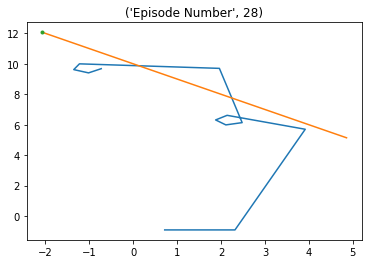

Current Episode: 29 Current Time Step: 0
Current Episode: 29 Current Time Step: 25
Episode * 29 * Avg Reward is ==> 306.2085272186882


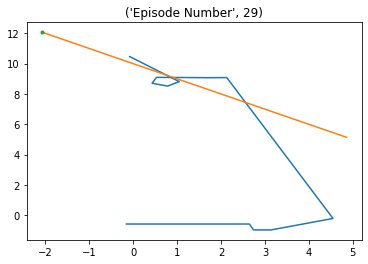

Current Episode: 30 Current Time Step: 0
Current Episode: 30 Current Time Step: 25
Episode * 30 * Avg Reward is ==> 309.71439514929705


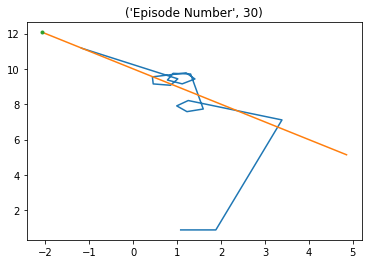

Current Episode: 31 Current Time Step: 0
Current Episode: 31 Current Time Step: 25
Episode * 31 * Avg Reward is ==> 310.87926640613597


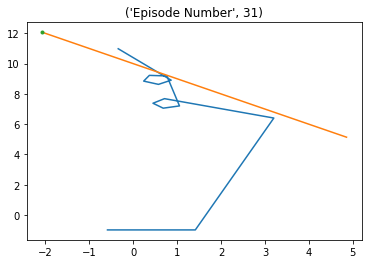

Current Episode: 32 Current Time Step: 0
Current Episode: 32 Current Time Step: 25
Episode * 32 * Avg Reward is ==> 313.64614041339917


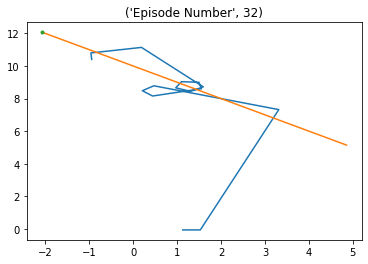

Current Episode: 33 Current Time Step: 0
Current Episode: 33 Current Time Step: 25
Episode * 33 * Avg Reward is ==> 314.7098390303371


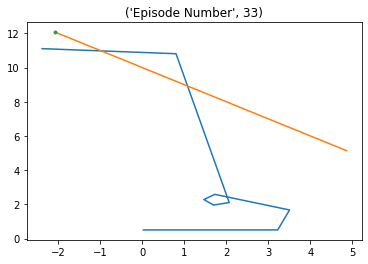

Current Episode: 34 Current Time Step: 0
Current Episode: 34 Current Time Step: 25
Episode * 34 * Avg Reward is ==> 316.9568098177751


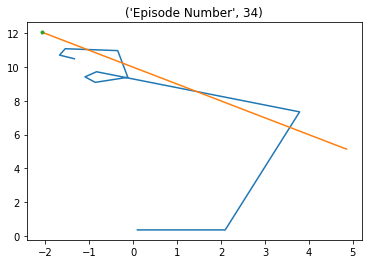

Current Episode: 35 Current Time Step: 0
Current Episode: 35 Current Time Step: 25
Episode * 35 * Avg Reward is ==> 316.77305626355917


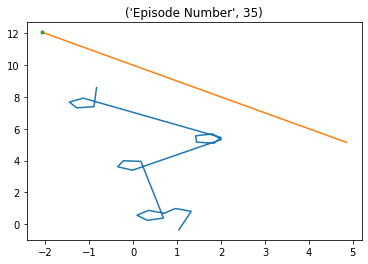

Current Episode: 36 Current Time Step: 0
Current Episode: 36 Current Time Step: 25
Episode * 36 * Avg Reward is ==> 318.94010583083997


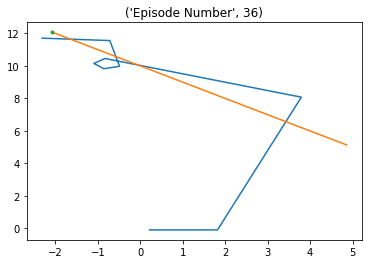

Current Episode: 37 Current Time Step: 0
Current Episode: 37 Current Time Step: 25
Episode * 37 * Avg Reward is ==> 321.2277138960042


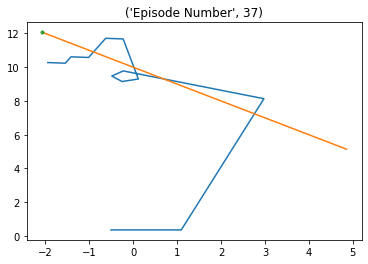

Current Episode: 38 Current Time Step: 0
Current Episode: 38 Current Time Step: 25
Episode * 38 * Avg Reward is ==> 321.8203773212128


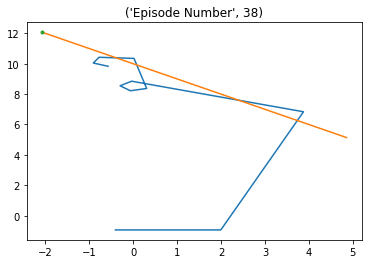

Current Episode: 39 Current Time Step: 0
Current Episode: 39 Current Time Step: 25
Episode * 39 * Avg Reward is ==> 323.61403489578817


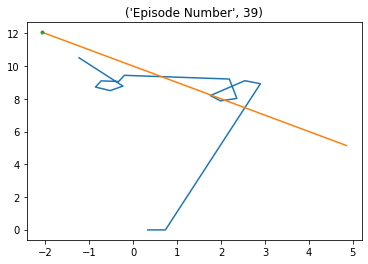

Current Episode: 40 Current Time Step: 0
Current Episode: 40 Current Time Step: 25
Episode * 40 * Avg Reward is ==> 324.84997083203535


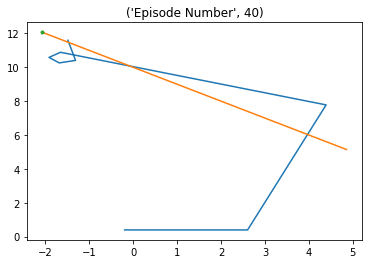

Current Episode: 41 Current Time Step: 0
Current Episode: 41 Current Time Step: 25
Episode * 41 * Avg Reward is ==> 328.11962947510705


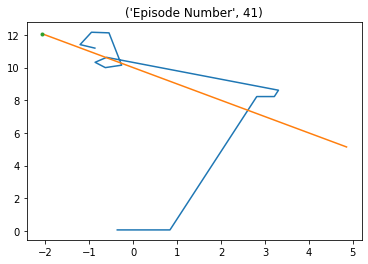

Current Episode: 42 Current Time Step: 0
Current Episode: 42 Current Time Step: 25
Episode * 42 * Avg Reward is ==> 332.6164676586254


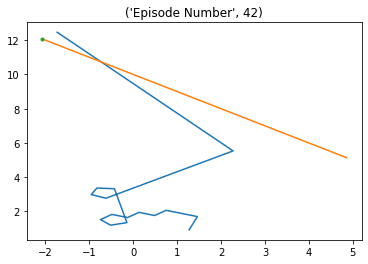

Current Episode: 43 Current Time Step: 0
Current Episode: 43 Current Time Step: 25
Episode * 43 * Avg Reward is ==> 338.42753549990147


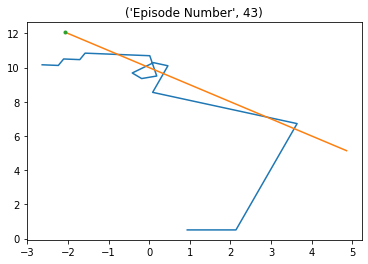

Current Episode: 44 Current Time Step: 0
Current Episode: 44 Current Time Step: 25
Episode * 44 * Avg Reward is ==> 343.11394500789777


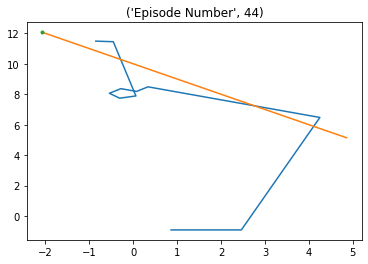

Current Episode: 45 Current Time Step: 0
Current Episode: 45 Current Time Step: 25
Episode * 45 * Avg Reward is ==> 347.2447333108388


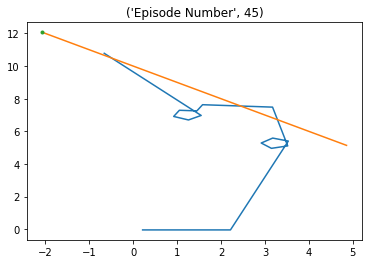

Current Episode: 46 Current Time Step: 0
Current Episode: 46 Current Time Step: 25
Episode * 46 * Avg Reward is ==> 353.4853219910592


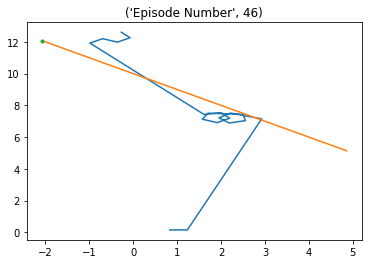

Current Episode: 47 Current Time Step: 0
Current Episode: 47 Current Time Step: 25
Episode * 47 * Avg Reward is ==> 355.5223648112438


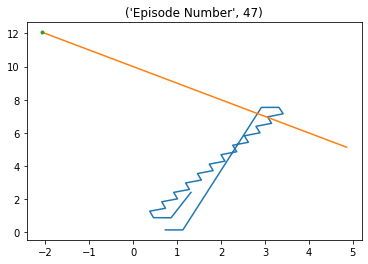

Current Episode: 48 Current Time Step: 0
Current Episode: 48 Current Time Step: 25
Episode * 48 * Avg Reward is ==> 360.1222879639518


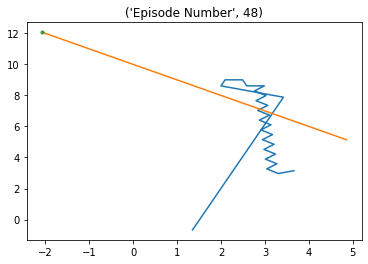

Current Episode: 49 Current Time Step: 0
Current Episode: 49 Current Time Step: 25
Episode * 49 * Avg Reward is ==> 363.89642409324415


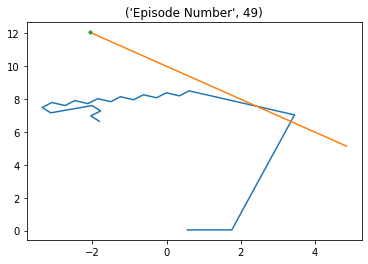

Current Episode: 50 Current Time Step: 0
Current Episode: 50 Current Time Step: 25
Episode * 50 * Avg Reward is ==> 361.23425920501234


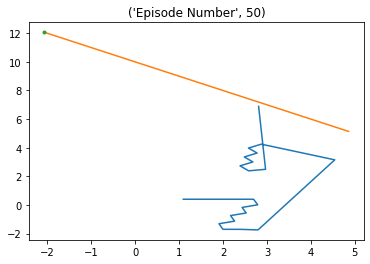

Current Episode: 51 Current Time Step: 0
Current Episode: 51 Current Time Step: 25
Episode * 51 * Avg Reward is ==> 363.2204213522162


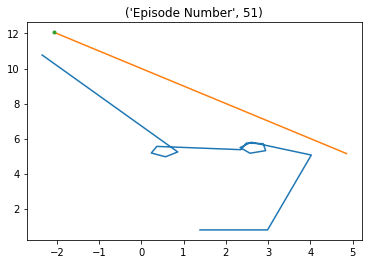

Current Episode: 52 Current Time Step: 0
Current Episode: 52 Current Time Step: 25
Episode * 52 * Avg Reward is ==> 362.6737519064959


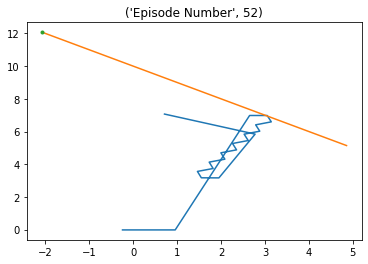

Current Episode: 53 Current Time Step: 0
Current Episode: 53 Current Time Step: 25
Episode * 53 * Avg Reward is ==> 363.42781977173183


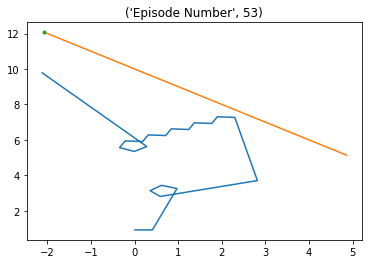

Current Episode: 54 Current Time Step: 0
Current Episode: 54 Current Time Step: 25
Episode * 54 * Avg Reward is ==> 364.971664132673


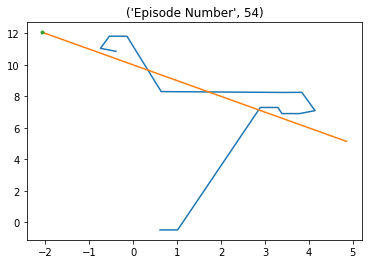

Current Episode: 55 Current Time Step: 0
Current Episode: 55 Current Time Step: 25
Episode * 55 * Avg Reward is ==> 365.2908712867205


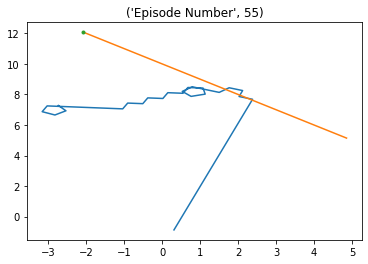

Current Episode: 56 Current Time Step: 0
Current Episode: 56 Current Time Step: 25
Episode * 56 * Avg Reward is ==> 364.83993239774657


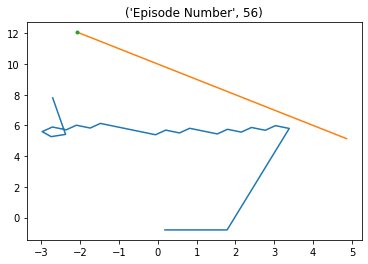

Current Episode: 57 Current Time Step: 0
Current Episode: 57 Current Time Step: 25
Episode * 57 * Avg Reward is ==> 364.01797603258143


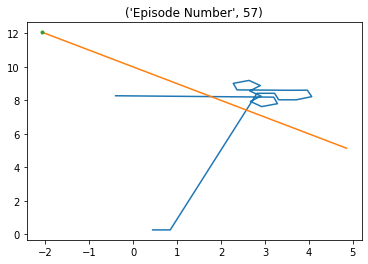

Current Episode: 58 Current Time Step: 0
Current Episode: 58 Current Time Step: 25
Episode * 58 * Avg Reward is ==> 364.84949106145814


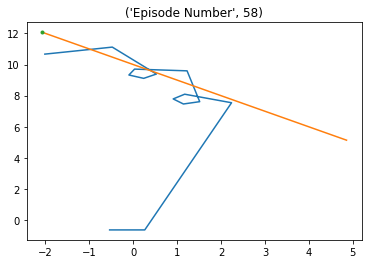

Current Episode: 59 Current Time Step: 0
Current Episode: 59 Current Time Step: 25
Episode * 59 * Avg Reward is ==> 365.02629014951333


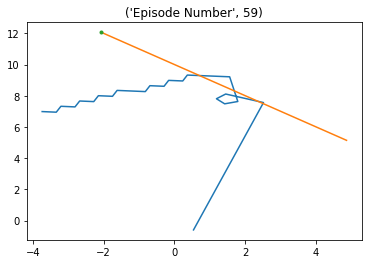

Current Episode: 60 Current Time Step: 0
Current Episode: 60 Current Time Step: 25
Episode * 60 * Avg Reward is ==> 363.5899244117701


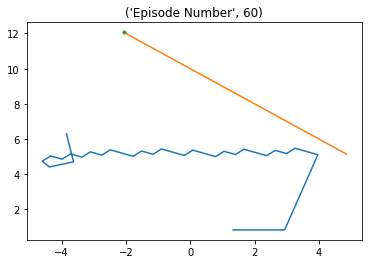

Current Episode: 61 Current Time Step: 0
Current Episode: 61 Current Time Step: 25
Episode * 61 * Avg Reward is ==> 365.5622116524073


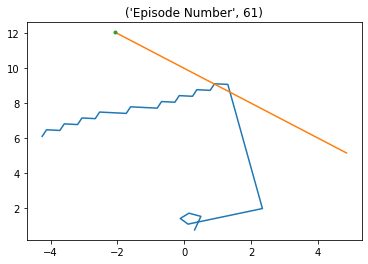

Current Episode: 62 Current Time Step: 0
Current Episode: 62 Current Time Step: 25
Episode * 62 * Avg Reward is ==> 365.46233785332413


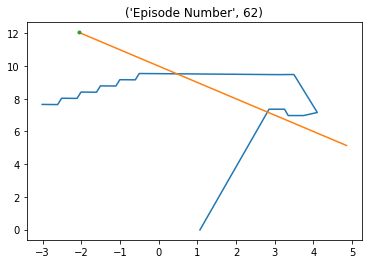

Current Episode: 63 Current Time Step: 0
Current Episode: 63 Current Time Step: 25
Episode * 63 * Avg Reward is ==> 364.42973929377115


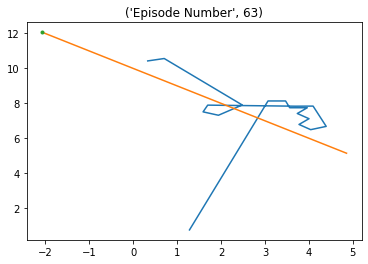

Current Episode: 64 Current Time Step: 0
Current Episode: 64 Current Time Step: 25
Episode * 64 * Avg Reward is ==> 362.28309034381084


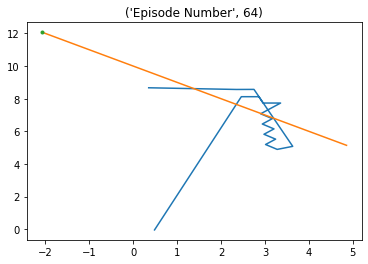

Current Episode: 65 Current Time Step: 0
Current Episode: 65 Current Time Step: 25
Episode * 65 * Avg Reward is ==> 361.71273271728717


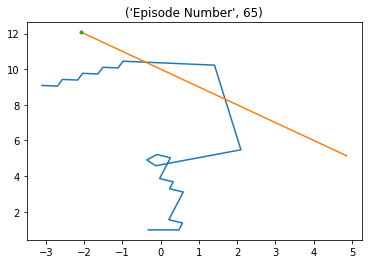

Current Episode: 66 Current Time Step: 0
Current Episode: 66 Current Time Step: 25
Episode * 66 * Avg Reward is ==> 361.01319542587646


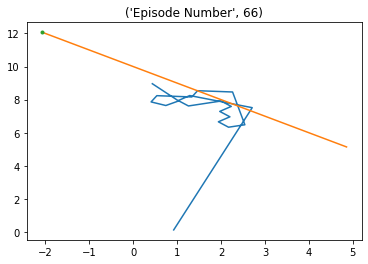

Current Episode: 67 Current Time Step: 0
Current Episode: 67 Current Time Step: 25
Episode * 67 * Avg Reward is ==> 360.0940362236132


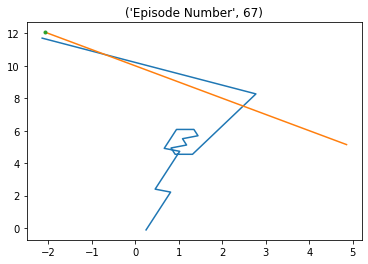

Current Episode: 68 Current Time Step: 0
Current Episode: 68 Current Time Step: 25
Episode * 68 * Avg Reward is ==> 359.8507586279232


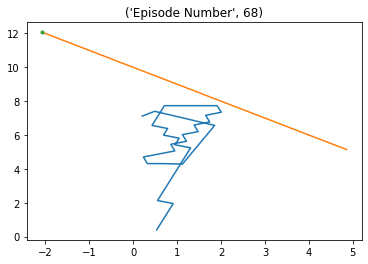

Current Episode: 69 Current Time Step: 0
Current Episode: 69 Current Time Step: 25
Episode * 69 * Avg Reward is ==> 360.4460092219589


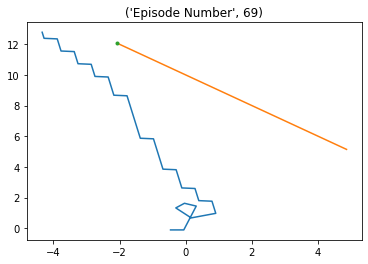

Current Episode: 70 Current Time Step: 0
Current Episode: 70 Current Time Step: 25
Episode * 70 * Avg Reward is ==> 360.1114434841603


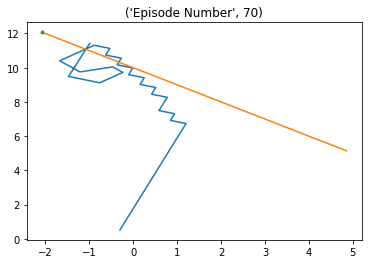

Current Episode: 71 Current Time Step: 0
Current Episode: 71 Current Time Step: 25
Episode * 71 * Avg Reward is ==> 360.8565434717365


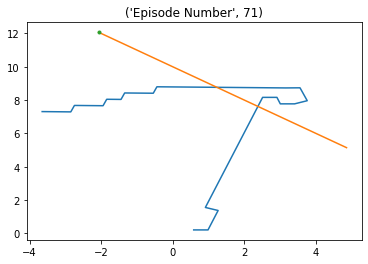

Current Episode: 72 Current Time Step: 0
Current Episode: 72 Current Time Step: 25
Episode * 72 * Avg Reward is ==> 359.4791018103563


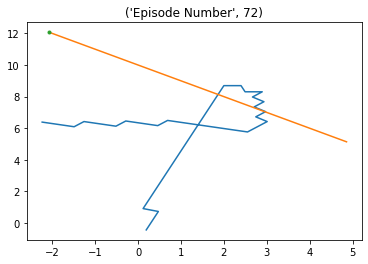

Current Episode: 73 Current Time Step: 0
Current Episode: 73 Current Time Step: 25
Episode * 73 * Avg Reward is ==> 359.4326638097115


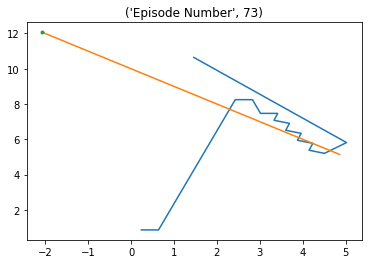

Current Episode: 74 Current Time Step: 0
Current Episode: 74 Current Time Step: 25
Episode * 74 * Avg Reward is ==> 359.3840217247744


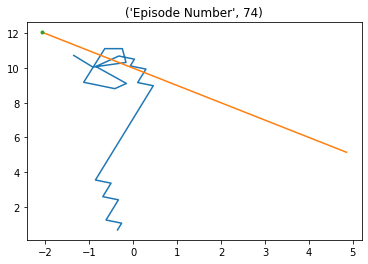

Current Episode: 75 Current Time Step: 0
Current Episode: 75 Current Time Step: 25
Episode * 75 * Avg Reward is ==> 359.0022031516531


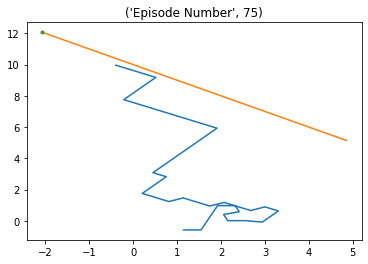

Current Episode: 76 Current Time Step: 0
Current Episode: 76 Current Time Step: 25
Episode * 76 * Avg Reward is ==> 357.7496960354621


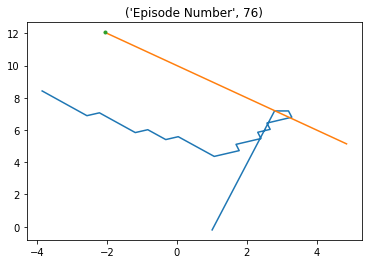

Current Episode: 77 Current Time Step: 0
Current Episode: 77 Current Time Step: 25
Episode * 77 * Avg Reward is ==> 356.78038397941515


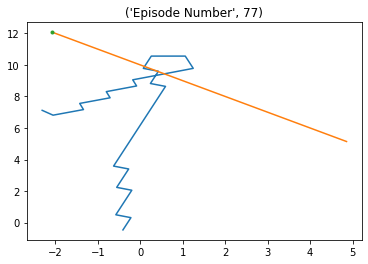

Current Episode: 78 Current Time Step: 0
Current Episode: 78 Current Time Step: 25
Episode * 78 * Avg Reward is ==> 358.16773504340006


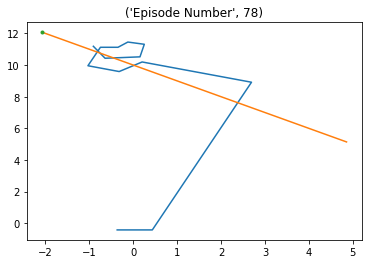

Current Episode: 79 Current Time Step: 0
Current Episode: 79 Current Time Step: 25
Episode * 79 * Avg Reward is ==> 358.87001911773706


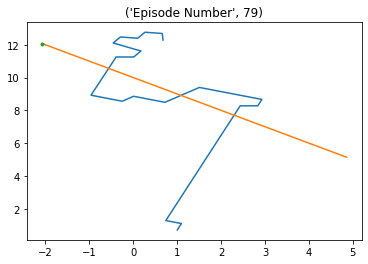

Current Episode: 80 Current Time Step: 0
Current Episode: 80 Current Time Step: 25
Episode * 80 * Avg Reward is ==> 357.43419015185333


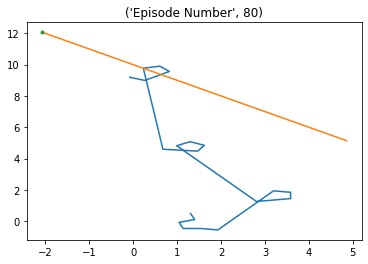

Current Episode: 81 Current Time Step: 0
Current Episode: 81 Current Time Step: 25
Episode * 81 * Avg Reward is ==> 356.61078837369917


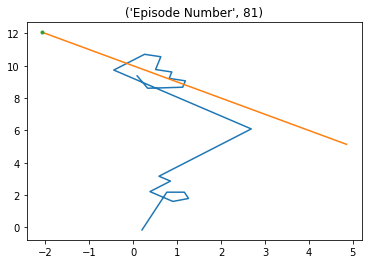

Current Episode: 82 Current Time Step: 0
Current Episode: 82 Current Time Step: 25
Episode * 82 * Avg Reward is ==> 352.9412278065


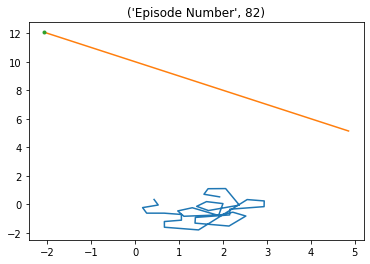

Current Episode: 83 Current Time Step: 0
Current Episode: 83 Current Time Step: 25
Episode * 83 * Avg Reward is ==> 348.3636328524464


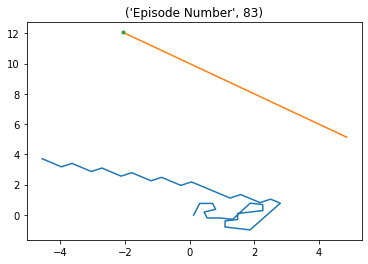

Current Episode: 84 Current Time Step: 0
Current Episode: 84 Current Time Step: 25
Episode * 84 * Avg Reward is ==> 345.4263453508026


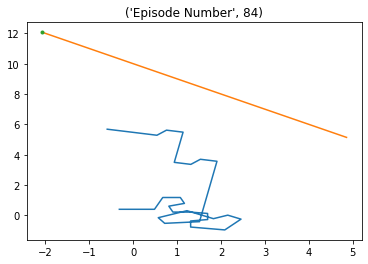

Current Episode: 85 Current Time Step: 0
Current Episode: 85 Current Time Step: 25
Episode * 85 * Avg Reward is ==> 346.1964094332367


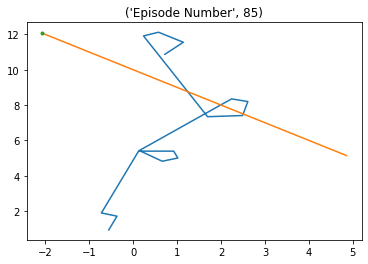

Current Episode: 86 Current Time Step: 0
Current Episode: 86 Current Time Step: 25
Episode * 86 * Avg Reward is ==> 345.07669153582066


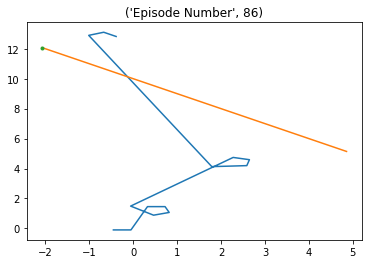

Current Episode: 87 Current Time Step: 0
Current Episode: 87 Current Time Step: 25
Episode * 87 * Avg Reward is ==> 345.6351559239992


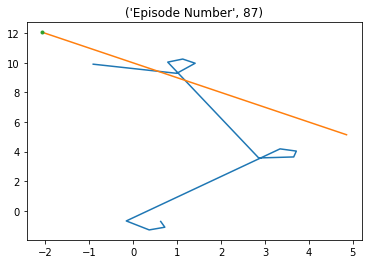

Current Episode: 88 Current Time Step: 0
Current Episode: 88 Current Time Step: 25
Episode * 88 * Avg Reward is ==> 342.00787642387684


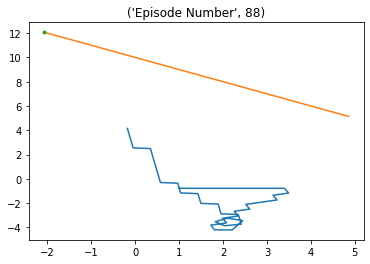

Current Episode: 89 Current Time Step: 0
Current Episode: 89 Current Time Step: 25
Episode * 89 * Avg Reward is ==> 340.8295065527476


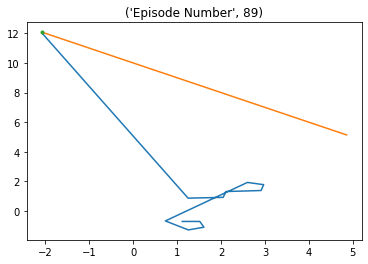

Current Episode: 90 Current Time Step: 0
Current Episode: 90 Current Time Step: 25
Episode * 90 * Avg Reward is ==> 344.3849823455775


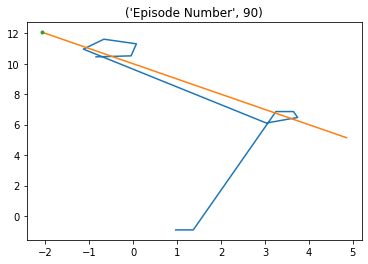

Current Episode: 91 Current Time Step: 0
Current Episode: 91 Current Time Step: 25


KeyboardInterrupt: ignored

In [ ]:


ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(EPISODES):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(50):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', e+1
    plt.title(title)
    plt.show()



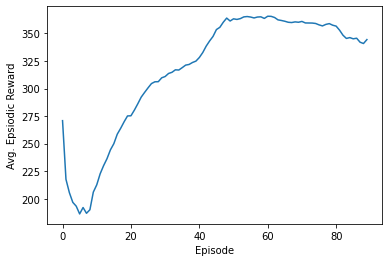

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.plot(avg_reward_list)

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Episode * 1 * Avg Reward is ==> 303.35816240714263


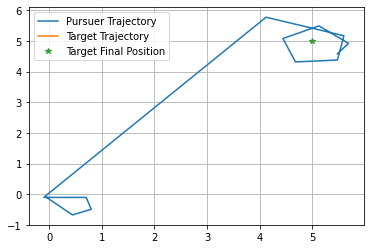

In [ ]:
import random

te = 5*np.pi/6
dt = 0.4
ve = 0.0
agent.epsilon = 0.0
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = +5.0
    self.e_ry = +5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    return state_p1_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    
    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(40):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        #agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)
        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        

        if d_p1_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()



Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Episode * 1 * Avg Reward is ==> 1149.0844181875443


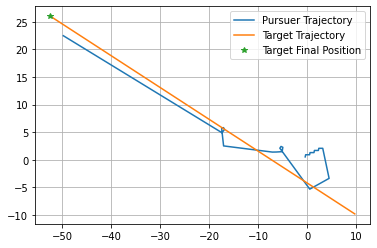

In [ ]:
import random

te = 5*np.pi/6
dt = 0.4
ve = 0.9
agent.epsilon = 0.0
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    return state_p1_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    
    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(200):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        #agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)
        if d_p1_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()


Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Episode * 1 * Avg Reward is ==> 1070.4241045536735


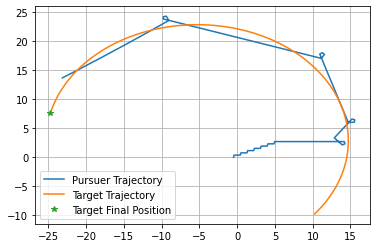

In [ ]:
import random

te = np.pi/4
rho_e = 2.0
ve = 0.9
dt = 0.4

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    return state_p1_e, state_e_p1
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions, theta_v_e):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    del_theta_v_e  = (ve/rho_e)*0.1*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_e  = theta_v_e  + del_theta_v_e
    
    #print(del_theta_v_e, theta_v_e, del_theta_v_e+theta_v_e)

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e, theta_v_e

  def step(self, actions, theta_v_e):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, theta_v_e = self.state_step(actions, theta_v_e)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs, theta_v_e



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []

    state_e_p1 = [env.e_rx, env.e_ry, env.e_vx, env.e_vy,
                  env.p1_rx, env.p1_ry]

    theta_v_e  = thetap(state_e_p1)


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(200):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state, theta_v_e = env.step(action, theta_v_e)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        #agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)
        if d_p1_e < 0.2:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1, label = 'Pursuer Trajectory')
    plt.plot(xce,yce, label = 'Target Trajectory')
    plt.plot(xc1,yc1,'*', label = 'Target Final Position')
    plt.legend()
    plt.grid()
    plt.show()


Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Episode * 1 * Avg Reward is ==> 696.8878230414432


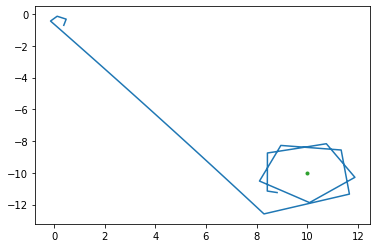

In [ ]:
import random
dt = 0.4
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = 0
    self.e_vy = 0
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    return state_p1_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    
    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + 0
    self.e_ry = self.e_ry + 0

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(100):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state = env.step(action)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        #agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    plt.show()



Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Current Episode: 1 Current Time Step: 50
Current Episode: 1 Current Time Step: 75
Current Episode: 1 Current Time Step: 100
Current Episode: 1 Current Time Step: 125
Current Episode: 1 Current Time Step: 150
Current Episode: 1 Current Time Step: 175
Current Episode: 1 Current Time Step: 200
Current Episode: 1 Current Time Step: 225
Current Episode: 1 Current Time Step: 250
Current Episode: 1 Current Time Step: 275
Current Episode: 1 Current Time Step: 300
Current Episode: 1 Current Time Step: 325
Current Episode: 1 Current Time Step: 350
Current Episode: 1 Current Time Step: 375
Current Episode: 1 Current Time Step: 400
Current Episode: 1 Current Time Step: 425
Current Episode: 1 Current Time Step: 450
Current Episode: 1 Current Time Step: 475
Current Episode: 1 Current Time Step: 500
Current Episode: 1 Current Time Step: 525
Current Episode: 1 Current Time Step: 550
Current Episode: 1 Current Time Step: 5

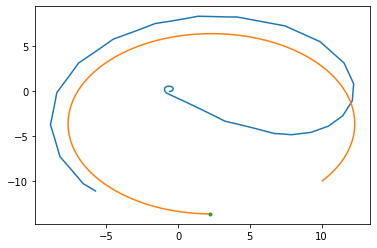

In [ ]:
import random

te = np.pi/4
rho_e = 10.0
ve = 0.9
dt = 0.1

class environment:
  def __init__(self):
    self.p1_rx = random.uniform(-1.0, 1.0)
    self.p1_ry = random.uniform(-1.0, 1.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.e_rx = +10.0
    self.e_ry = -10.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    return state_p1_e, state_e_p1
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0]
    return obs

  def state_step(self, actions, theta_v_e):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    theta_v_p1 = thetap(state_p1_e)
    
    
    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(actions-1.0)/1.0*dt
    del_theta_v_e  = (ve/rho_e)*1.0*dt
    
    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_e  = theta_v_e  + del_theta_v_e
    
    #print(del_theta_v_e, theta_v_e, del_theta_v_e+theta_v_e)

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    
    return state_p1_e, theta_v_e

  def step(self, actions, theta_v_e):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, theta_v_e = self.state_step(actions, theta_v_e)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    #print(obs)
    
    return obs, theta_v_e



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(1):
    env = environment()
    prev_state = env.initial_obs()


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xce = []
    yce = []

    state_e_p1 = [env.e_rx, env.e_ry, env.e_vx, env.e_vy,
                  env.p1_rx, env.p1_ry]

    theta_v_e  = thetap(state_e_p1)


    prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(600):
        # env.render()
        action = agent.act(prev_state)
        #print(action)

        next_state, theta_v_e = env.step(action, theta_v_e)
        #print(next_state)
        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        #agent.memorize(prev_state, action, rew, next_state)
        prev_state = next_state
        #print(action)
        
        

        episodic_reward += rew
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    plt.show()

